In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from scipy.fftpack import fft, ifft
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

In [2]:
def initialize_all(y0, t0, t1, n):
    """ An initialization routine for the different ODE solving
    methods in the lab. This initializes Y, T, and h. """
    if isinstance(y0, np.ndarray):
        Y = np.empty((n, y0.size),dtype=complex).squeeze()
    else:
        Y = np.empty(n,dtype=complex)
    Y[0] = y0
    T = np.linspace(t0, t1, n)
    h = float(t1 - t0) / (n - 1)
    return Y, T, h

def RK4(f, y0, t0, t1, n):
    """ Use the RK4 method to compute an approximate solution
    to the ODE y' = f(t, y) at n equispaced parameter values from t0 to t
    with initial conditions y(t0) = y0.
    'y0' is assumed to be either a constant or a one-dimensional numpy array.
    't0' and 't1' are assumed to be constants.
    'f' is assumed to accept two arguments.
    The first is a constant giving the current value of t.
    The second is a one-dimensional numpy array of the same size as y.
    This function returns an array Y of shape (n,) if
    y is a constant or an array of size 1.
    It returns an array of shape (n, y.size) otherwise.
    In either case, Y[i] is the approximate value of y at
    the i'th value of np.linspace(t0, t, n).
    """
    Y, T, h = initialize_all(y0, t0, t1, n)
    for i in range(1, n):
        K1 = f(T[i-1], Y[i-1])
        tplus = (T[i] + T[i-1]) * .5
        K2 = f(tplus, Y[i-1] + .5 * h * K1)
        K3 = f(tplus, Y[i-1] + .5 * h * K2)
        K4 = f(T[i], Y[i-1] + h * K3)
        Y[i] = Y[i-1] + (h / 6.) * (K1 + 2 * K2 + 2 * K3 + K4)
    return T, Y

# Problem 1

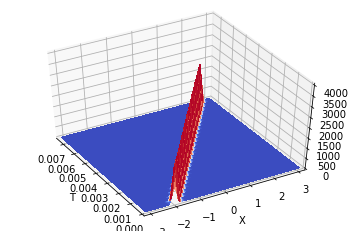

In [5]:
N = 256

# Array of wave numbers. This array is reordered in Python to
# accomodate the ordering inside the fft function in scipy.
k = np.concatenate(( np.arange(0,N/2) ,
    np.array([0]) ,
    np.arange(-N/2+1,0,1) )).reshape(N,)


# Defines the left hand side of the ODE y' = G(t,y)
# defined above.
ik3 = 1j*k**3.
def G_unscaled(t,y):
    out = -.5*1j*k*fft(ifft(y,axis=0)**2.,axis=0) + ik3*y
    return out

# Discretize the space
x = ((2.*np.pi)/N) * np.arange(-N/2,N/2).reshape(N,1) 

# Initial data is a soliton
s, shift = 25.**2., 2.                                         
y_0 = (3.*s*np.cosh(.5*(sqrt(s)*(x + shift)))**(-2.)).reshape(N,)

# Solve the differential equation
t_max = .0075
dt = .02*N**(-2)
t_maxsteps = int(round(t_max/dt))
y_0 = fft(y_0,axis=0)
T,Y = RK4(G_unscaled, y_0, t0=0, t1=t_max, n=t_maxsteps)

# Using the variable stride, apply the fft to the data
# one step at a time
stride = int(np.floor((t_max/25.)/dt))
u_vals, t_vals = np.real(ifft(y_0,axis=0)).reshape(N,1), np.array(0.).reshape(1,1)
for n in range(1,t_maxsteps + 1):
    if np.mod(n,stride) == 0:
        t = n*dt
        u = np.real(ifft(Y[n], axis=0)).reshape(N,1)
        u_vals = np.concatenate((u_vals,np.nan_to_num(u)),axis=1)
        t_vals = np.concatenate((t_vals,np.array(t).reshape(1,1)),axis=1)

# Plot the results        
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.view_init(elev=45., azim=150)
tv, xv = np.meshgrid(t_vals,x,indexing='ij')
surface = ax.plot_surface(tv,xv, u_vals.T, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
t_vals = t_vals[0]
ax.set_xlim(t_vals[0], t_vals[-1])
ax.set_ylim(-np.pi, np.pi)
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_zlim(0., 4000.)
ax.set_xlabel('T') 
ax.set_ylabel('X') 
ax.set_zlabel('Z')
plt.show()

# Problem 2

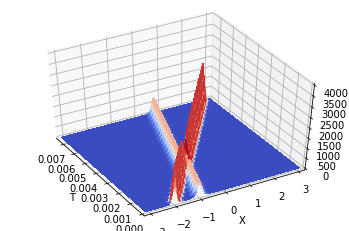

In [6]:
x = (2.*np.pi/N)*np.arange(-N/2,N/2).reshape(N,1)              # Space discretization
s1, shift1 = 25.**2., 2.                                       # Initial data is a soliton
s2, shift2 = 16.**2., 1.                                       # Initial data is a soliton

term1 = (3.*s1*np.cosh(.5*(sqrt(s1)*(x+shift1)))**(-2.)).reshape(N,)
term2 = (3.*s2*np.cosh(.5*(sqrt(s2)*(x+shift2)))**(-2.)).reshape(N,)
y0    = term1 + term2

# Solves the differential equation
max_t = .0075
dt = .02*N**(-2)
max_tsteps = int(round(max_t/dt))
y0 = fft(y0,axis=0)
T,Y = RK4(G_unscaled, y0, t0=0, t1=max_t, n=max_tsteps)

# Using the variable stride, apply the fft to the data
# one step at a time
stride = int(np.floor((max_t/25.)/dt))
u_vals, t_vals = np.real(ifft(y0,axis=0)).reshape(N,1), np.array(0.).reshape(1,1)
for n in range(1,max_tsteps + 1):
    if np.mod(n,stride) == 0:
        t = n*dt
        u = np.real(ifft(Y[n], axis=0)).reshape(N,1)
        u_vals = np.concatenate((u_vals,np.nan_to_num(u)),axis=1)
        t_vals = np.concatenate((t_vals,np.array(t).reshape(1,1)),axis=1)

# Plot the results        
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.view_init(elev=45., azim=150)
tv, xv = np.meshgrid(t_vals,x,indexing='ij')
surface = ax.plot_surface(tv,xv, u_vals.T, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
t_vals = t_vals[0]
ax.set_xlim(t_vals[0], t_vals[-1])
ax.set_ylim(-np.pi, np.pi)
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_zlim(0., 4000.)
ax.set_xlabel('T')
ax.set_ylabel('X')
ax.set_zlabel('Z')
plt.show()

# Problem 3

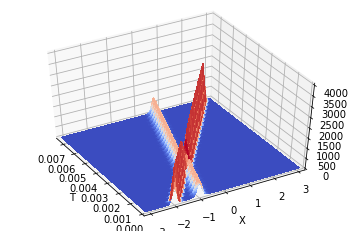

In [19]:
N = 256

# Array of wave numbers. This array is reordered in Python to
# accomodate the ordering inside the fft function in scipy.
k = np.concatenate(( np.arange(0,N/2) ,
    np.array([0]) ,
    np.arange(-N/2+1,0,1) )).reshape(N,)


# Defines the left hand side of the ODE y' = G(t,y)
# defined above.
ik3 = 1j*k**3.
def G_unscaled(t,z):
    out = -.5*1j*k*fft(ifft(z*np.exp(ik3*t),axis=0)**2.,axis=0)* np.exp(-ik3*t) 
    return out


x = (2.*np.pi/N)*np.arange(-N/2,N/2).reshape(N,1)              # Space discretization
s1, shift1 = 25.**2., 2.                                       # Initial data is a soliton
s2, shift2 = 16.**2., 1.                                       # Initial data is a soliton

term1 = (3.*s1*np.cosh(.5*(sqrt(s1)*(x + shift1)))**(-2.)).reshape(N,)
term2 = (3.*s2*np.cosh(.5*(sqrt(s2)*(x + shift2)))**(-2.)).reshape(N,)
y0    = term1 + term2

# Solves the differential equation
max_t = .0075
dt = .02*N**(-2)
max_tsteps = int(round(max_t/dt))
y0 = fft(y0,axis=0)
T,Z = RK4(G_unscaled, y0, t0=0, t1=max_t, n=max_tsteps)

# Using the variable stride, apply the fft to the data
# one step at a time
stride = int(np.floor((max_t/25.)/dt))
u_vals, t_vals = np.real(ifft(y0,axis=0)).reshape(N,1), np.array(0.).reshape(1,1)
for n in range(1,max_tsteps+1):
    if np.mod(n,stride) == 0:
        t = n*dt
        u = np.real( ifft(np.exp(ik3*t)*Z[n], axis=0) ).reshape(N,1)
        u_vals = np.concatenate((u_vals,np.nan_to_num(u)),axis=1)
        t_vals = np.concatenate((t_vals,np.array(t).reshape(1,1)),axis=1)

# Plot the results        
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.view_init(elev=45., azim=150)
tv, xv = np.meshgrid(t_vals,x,indexing='ij')
surf = ax.plot_surface(tv,xv, u_vals.T, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
t_vals = t_vals[0]
ax.set_xlim(t_vals[0], t_vals[-1])
ax.set_ylim(-np.pi, np.pi)
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_zlim(0., 4000.)
ax.set_xlabel('T')
ax.set_ylabel('X')
ax.set_zlabel('Z')
plt.show()